In [32]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    'train',
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical')

validation_generator = validation_data_gen.flow_from_directory(
        'test',
        target_size=(48, 48),
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


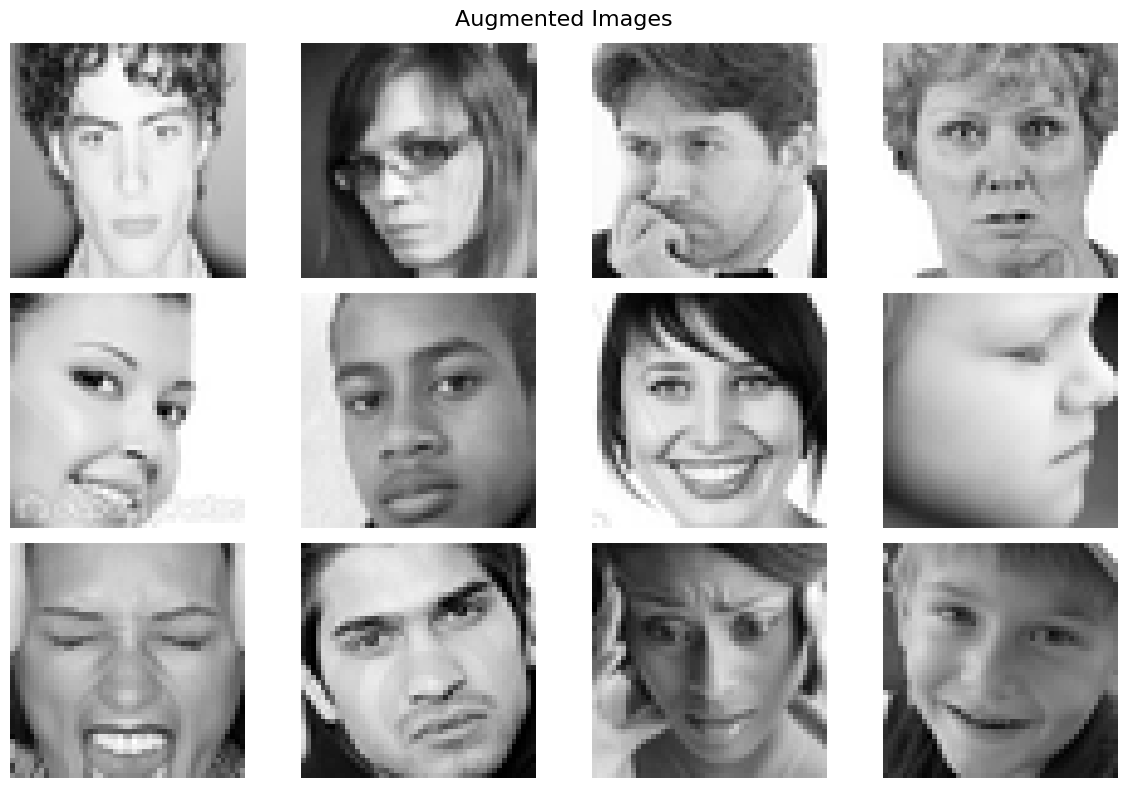

In [21]:
# Get a batch of images and labels
data_batch, label_batch = next(train_generator)

# Display augmented images
plt.figure(figsize=(12, 8))
for i in range(12):  # Display 12 images
    plt.subplot(3, 4, i + 1)
    plt.imshow(data_batch[i].squeeze(), cmap='gray')  # Ensure grayscale display
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()


In [22]:
import os

train_dir = "train"  # Update this if needed
classes = os.listdir(train_dir)  # Get class folder names

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Print results
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} images")


Class neutral: 4965 images
Class disgusted: 436 images
Class fearful: 4097 images
Class surprised: 3171 images
Class sad: 4830 images
Class happy: 7215 images
Class angry: 3995 images


In [23]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                         input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

emotion_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
cv2.ocl.setUseOpenCL(False)

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, 
                               decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)

emotion_model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                      metrics=['accuracy'])

In [25]:
emotion_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)


/home/ahsan/Notebooks/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 175s 385ms/step - accuracy: 0.2411 - loss: 1.8284 - val_accuracy: 0.3435 - val_loss: 1.7006
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 165s 366ms/step - accuracy: 0.3484 - loss: 1.6632 - val_accuracy: 0.3941 - val_loss: 1.5674
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 164s 364ms/step - accuracy: 0.4020 - loss: 1.5479 - val_accuracy: 0.4320 - val_loss: 1.4857
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.4325 - loss: 1.4718 - val_accuracy: 0.4653 - val_loss: 1.4028
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 149s 331ms/step - accuracy: 0.4594 - loss: 1.4148 - val_accuracy: 0.4882 - val_loss: 1.3535
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 162s 360ms/step - accuracy: 0.4765 - loss: 1.3674 - val_accuracy: 0.4997 - val_loss: 1.3110
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 160s 355ms/step - accuracy: 0.5042 - loss: 1.3129 - val_accuracy: 0.5109 - val_loss: 1.2763
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 162s 361ms/step - accuracy: 0.5210 -

In [26]:
emotion_model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.6107 - loss: 1.0951


[1.0842419862747192, 0.6170242428779602]

In [33]:
# Get true labels & predictions
y_true = validation_generator.classes
y_pred = emotion_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step


<Figure size 1600x1000 with 0 Axes>

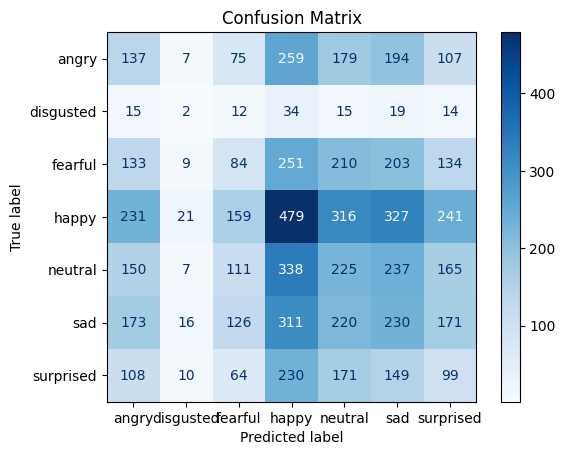

In [34]:
# Display confusion matrix
plt.figure(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [35]:
# Save Model
emotion_model.save("emotion_recognition_model.h5")

In [36]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the trained model
model = load_model("emotion_recognition_model.h5")

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Define class labels (update these based on your dataset)
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [37]:
# Open webcam
cap = cv2.VideoCapture(0)  # Use 0 for built-in webcam

while True:
    # Read frame from webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale (as FER models are trained on grayscale images)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract face ROI (Region of Interest)
        face_roi = gray[y:y+h, x:x+w]

        # Resize to match model input size (48x48)
        face_resized = cv2.resize(face_roi, (48, 48))
        face_resized = np.expand_dims(face_resized, axis=-1)  # Add channel dimension
        face_resized = np.expand_dims(face_resized, axis=0)   # Add batch dimension
        face_resized = face_resized / 255.0  # Normalize

        # Predict emotion
        prediction = model.predict(face_resized)
        emotion_label = class_labels[np.argmax(prediction)]  # Get the label with highest probability

        # Draw rectangle around face & display emotion label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Emotion Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/ste